In [51]:
import sys
import os
import pathlib
import glob
import zipfile
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dateutil import parser
# from datetime import datetime, timedelta
import sweetviz as sv

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from flexitext import flexitext

In [2]:
%load_ext autoreload
%autoreload 2

from helper_functions import visualization

In [3]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

In [5]:
# Import the data
used_stasiun = "Bekasi Kayuringin"
raw_klhk_jkt_dir = raw_data_dir / "klhk_jkt"

# aqi data
klhk_jkt_list = glob.glob(f'{str(raw_klhk_jkt_dir)}/*.xlsx')

# coordinate data
klhk_jkt_coord = glob.glob(f'{str(raw_klhk_jkt_dir)}/*.zip')

In [5]:
raw_df = pd.concat([pd.read_excel(file) for file in klhk_jkt_list])
raw_df.head(2)

,Stasiun,Tanggal,Waktu,PM10,PM2.5,SO2,CO,O3,NO2,HC,PM 2.5 Sedang,PM 2.5 Tidak Sehat
0,Bantar Gebang,2023-06-01,00:00:00,93.0,131.0,0.0,22,12.0,9.0,0.0,55.4,150.4
1,Bantar Gebang,2023-06-01,01:00:00,91.0,129.0,0.0,22,12.0,9.0,0.0,55.4,150.4


In [6]:
# standardize column names
col_name_mapping = {_: _.lower() for _ in raw_df.columns}
processed_df = raw_df.copy()
processed_df = processed_df.rename(columns=col_name_mapping)

# create read_time column as datetime
processed_df['read_time'] = pd.to_datetime(processed_df['tanggal'].astype("str") + ' ' + processed_df['waktu'])
processed_df.drop(['tanggal', 'waktu'], axis=1, inplace=True)
processed_df = processed_df.sort_values(by=['stasiun', 'read_time'])

# there's "x" value in "co" column
processed_df['co'] = pd.to_numeric(processed_df['co'], errors='coerce')

# impute null values
# pm10, pm2.5, so2, co, o3, no2, hc
# https://drnesr.medium.com/filling-gaps-of-a-time-series-using-python-d4bfddd8c460
# https://www.section.io/engineering-education/missing-values-in-time-series/
# processed_df = processed_df.assign(InterpolateLinear=processed_df['pm2.5'].interpolate(method='linear'))

In [7]:
processed_df.head(2)

,stasiun,pm10,pm2.5,so2,co,o3,no2,hc,pm 2.5 sedang,pm 2.5 tidak sehat,read_time
0,Bantar Gebang,93.0,131.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 00:00:00
1,Bantar Gebang,91.0,129.0,0.0,22.0,12.0,9.0,0.0,55.4,150.4,2023-06-01 01:00:00


# Exploratory Data Analysis

In [8]:
# my_report = sv.analyze(processed_df)
# my_report.show_notebook()

## Lagged Scatter Plot

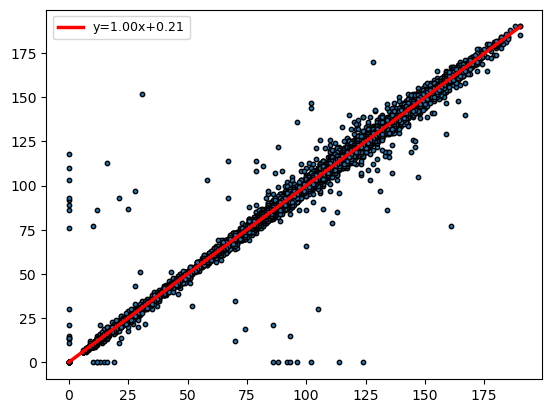

In [9]:
visualization.plot_lagged_scatter(
    processed_df,
    visualization.reg_line,
    parameter="pm2.5",
)

## Overall Plot

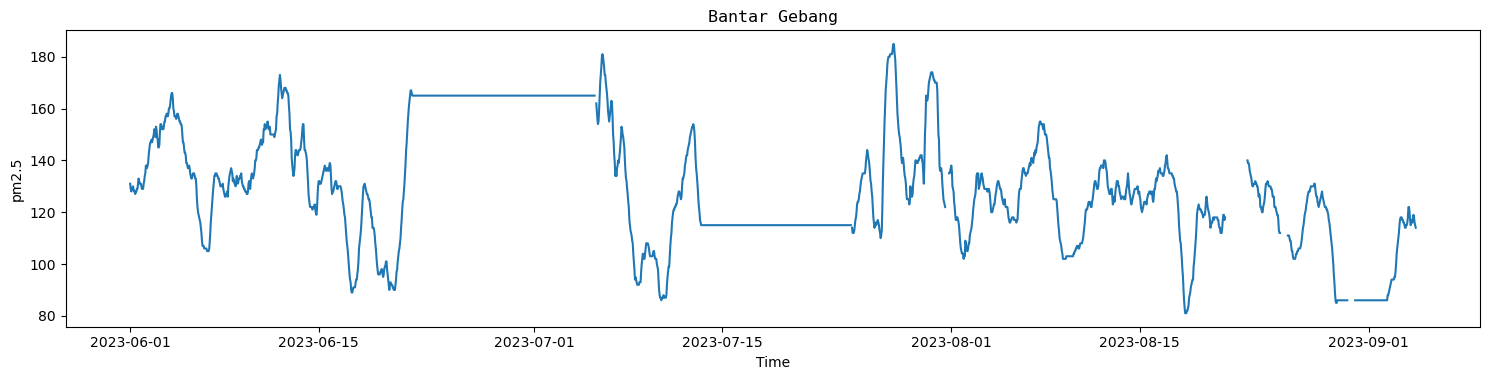

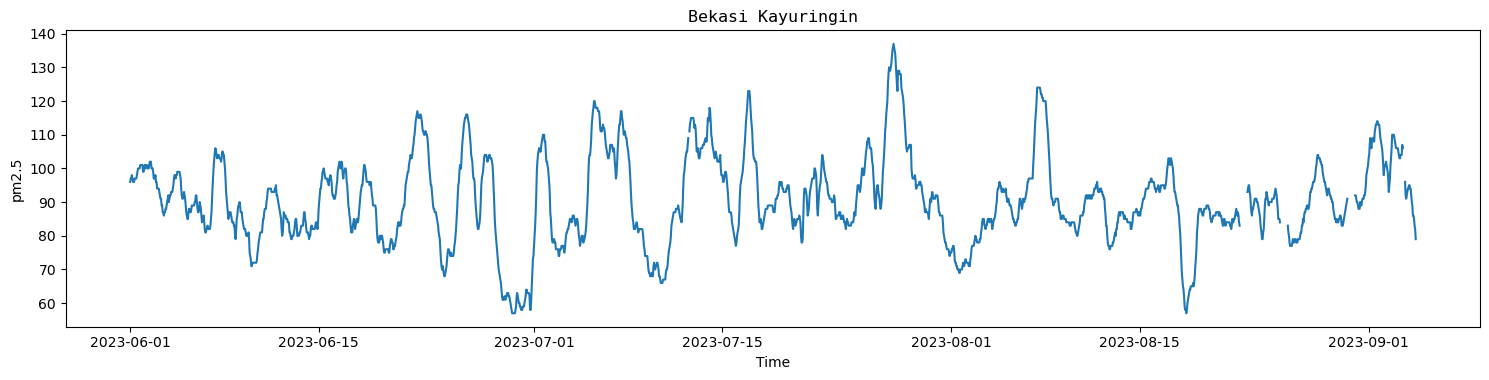

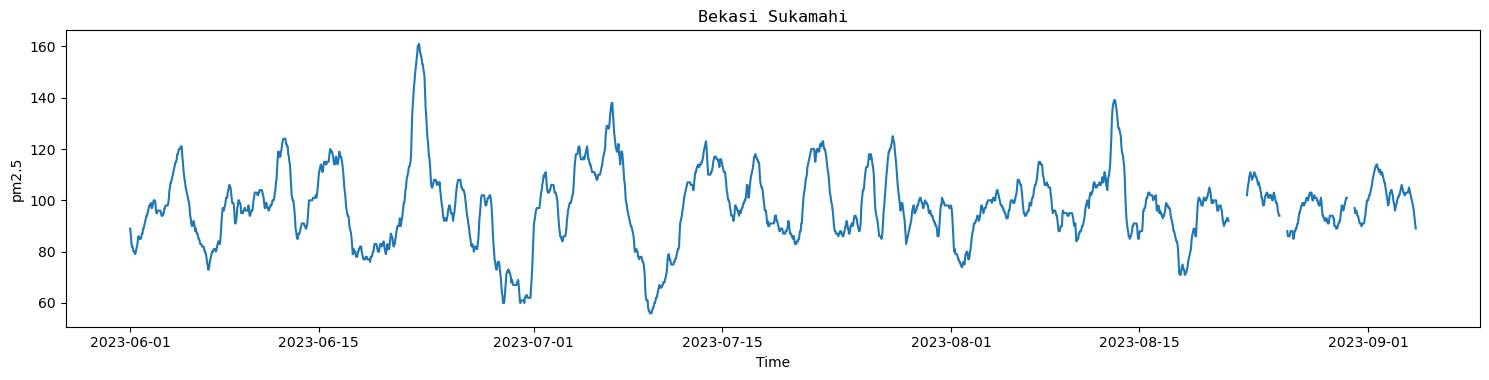

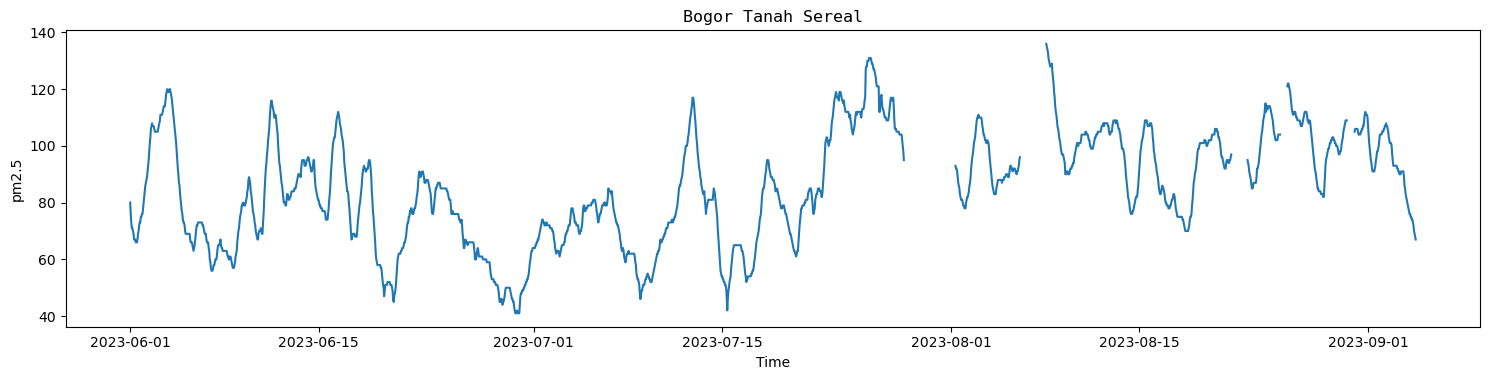

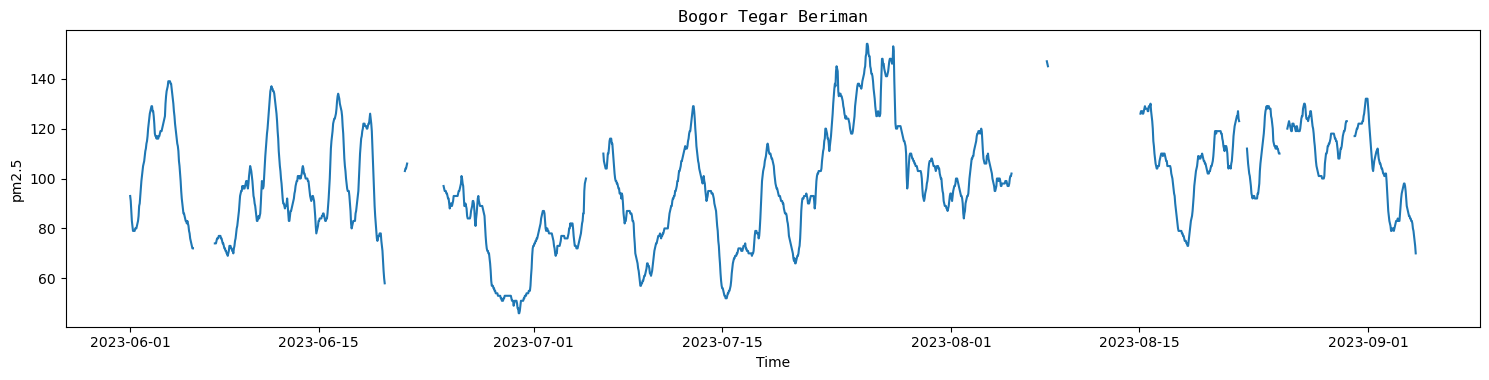

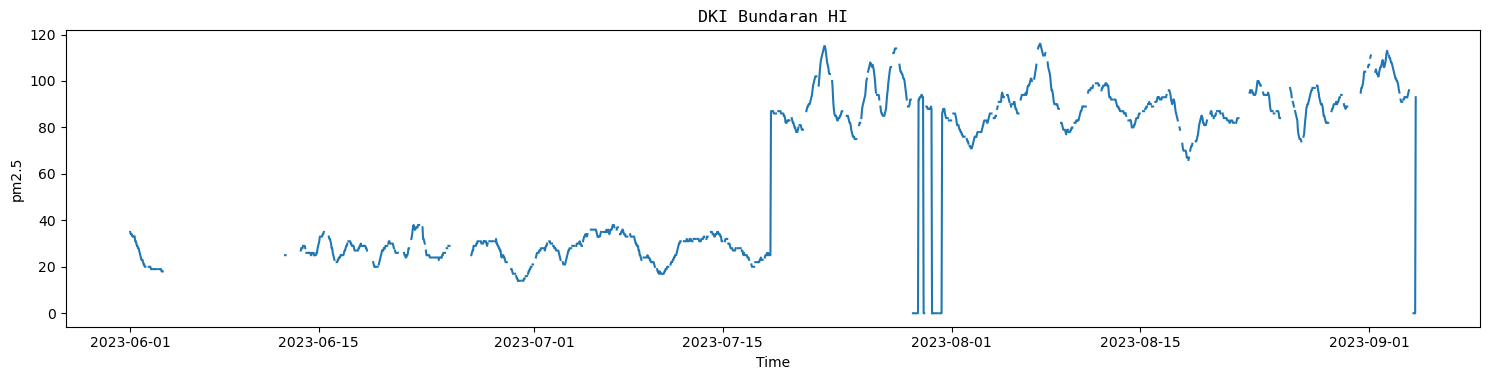

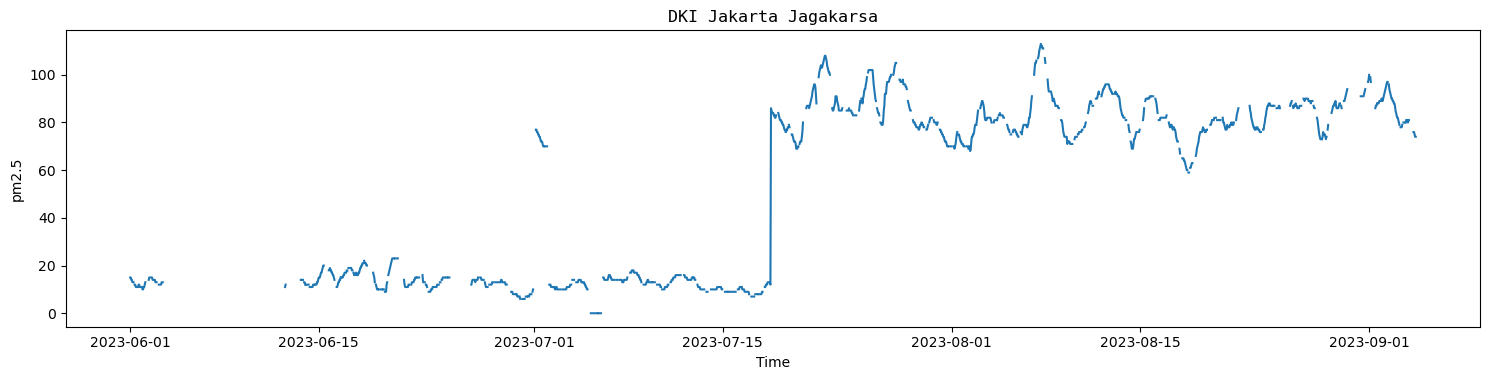

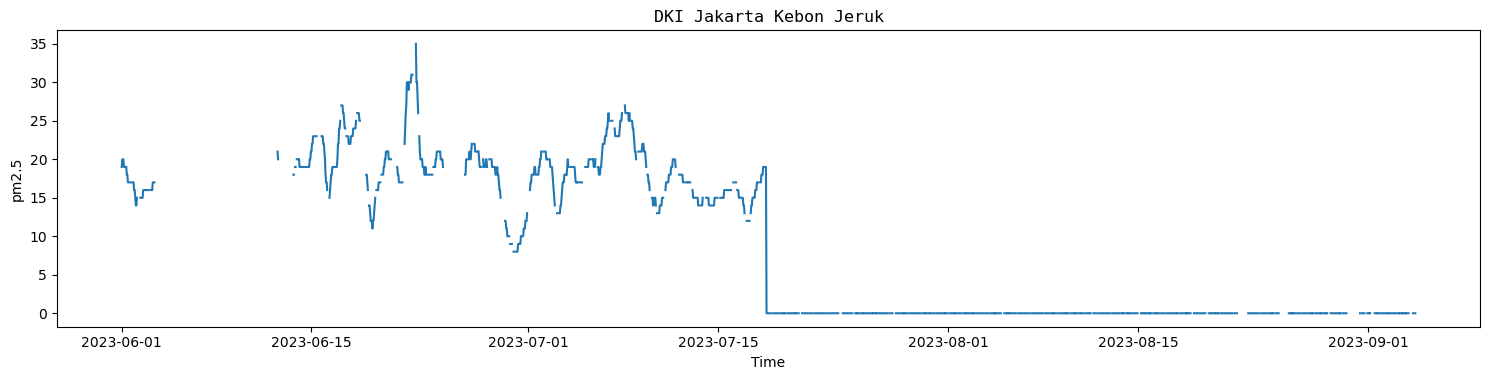

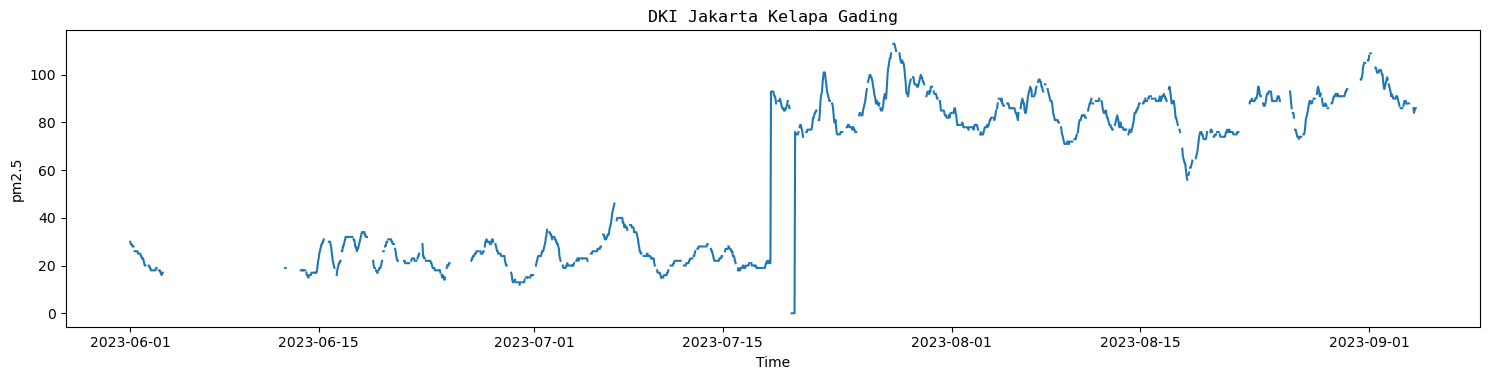

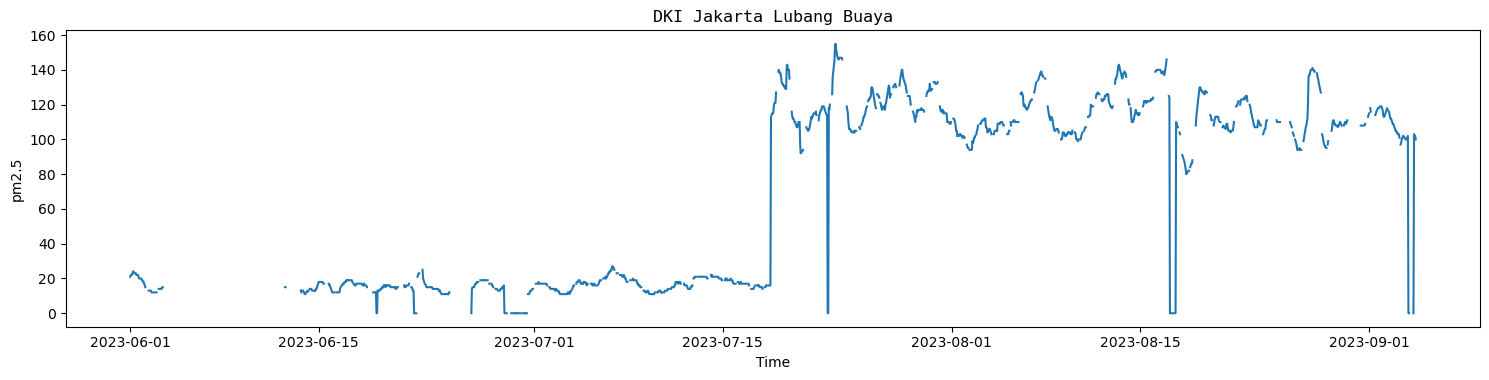

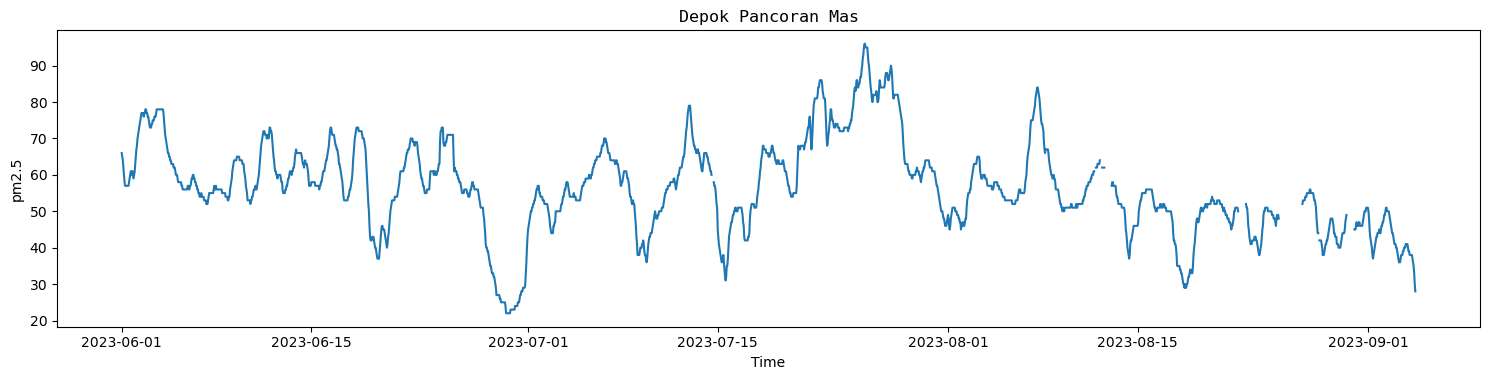

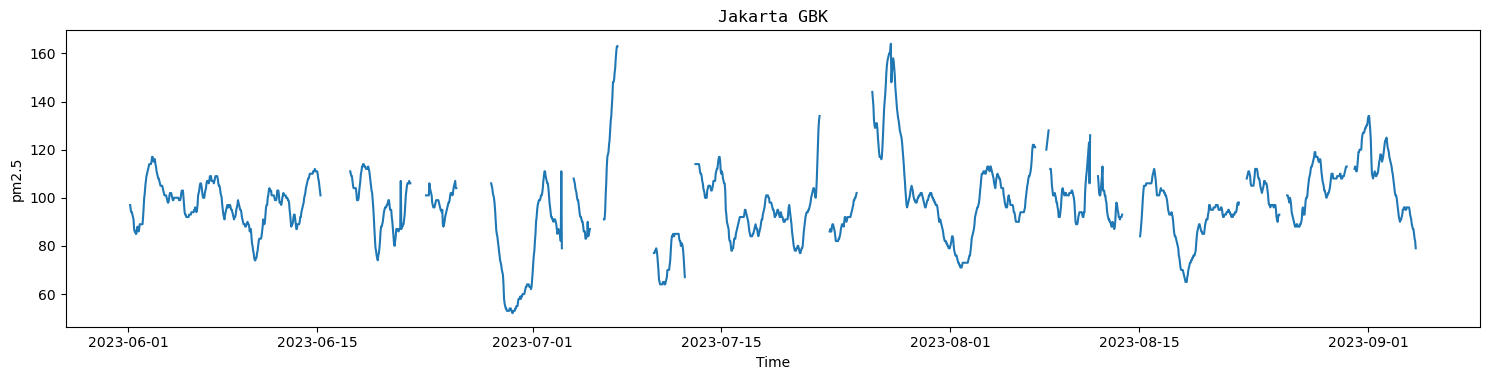

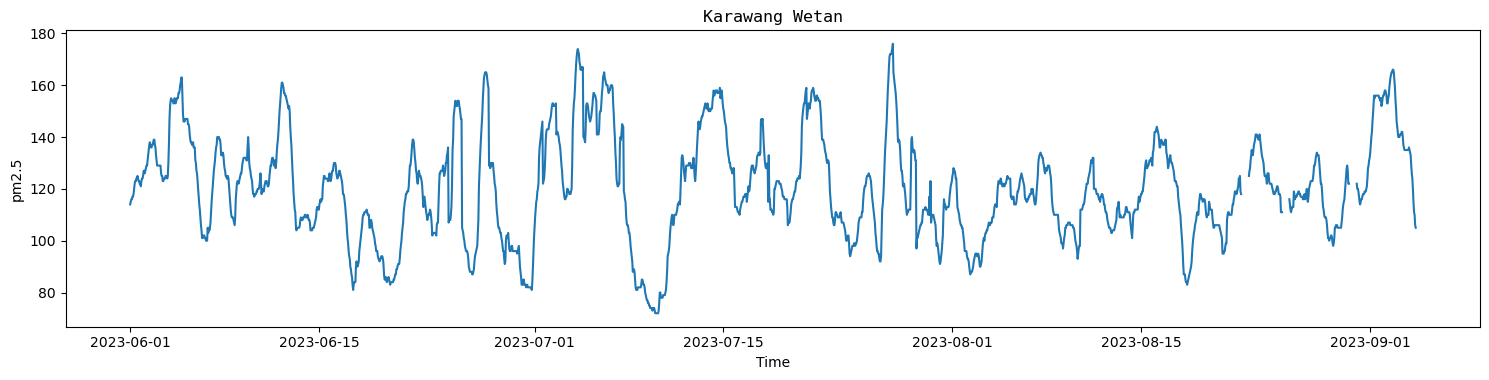

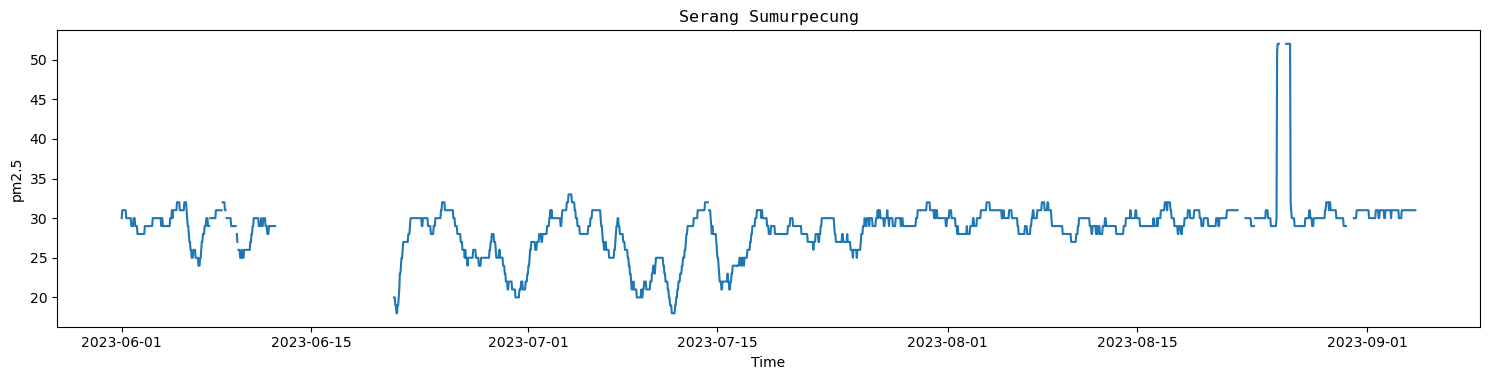

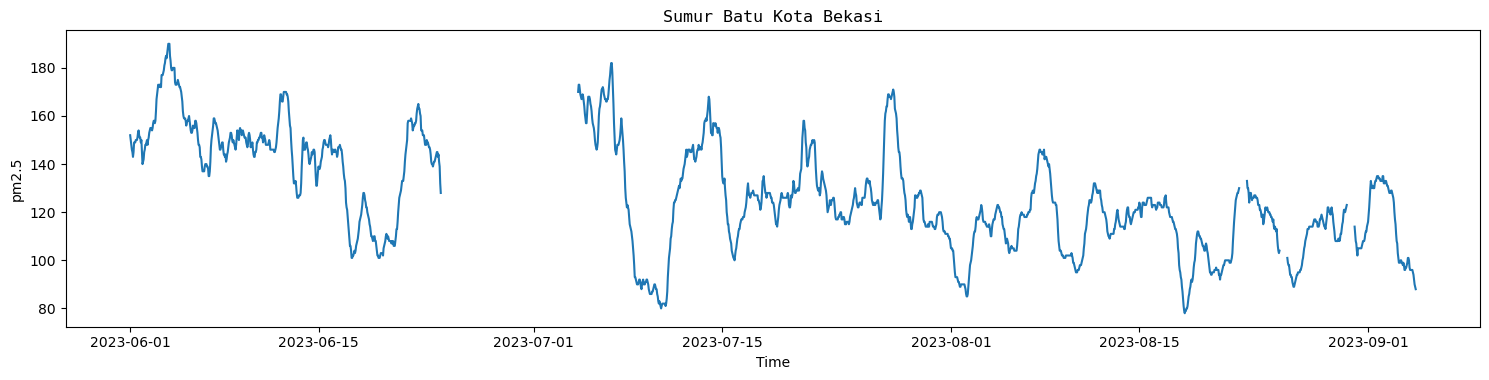

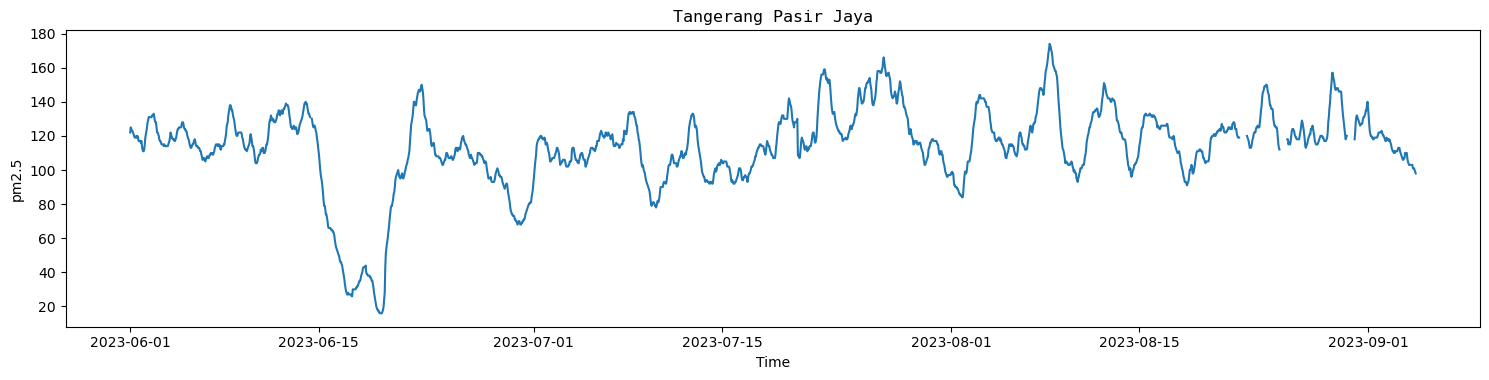

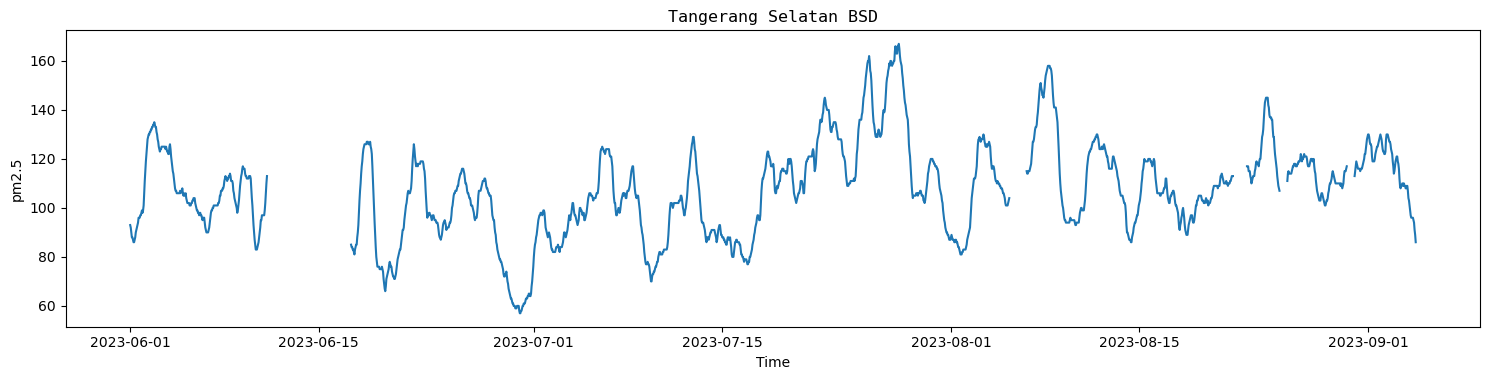

In [10]:
for stasiun in processed_df['stasiun'].unique():
    fig, ax = visualization.overall_plot(
        processed_df[processed_df['stasiun']==stasiun],
        'read_time',
        ["pm2.5"],
        1
    )
    ax.set_title(stasiun)

In [11]:
filtered_df = processed_df[processed_df['stasiun']==used_stasiun]

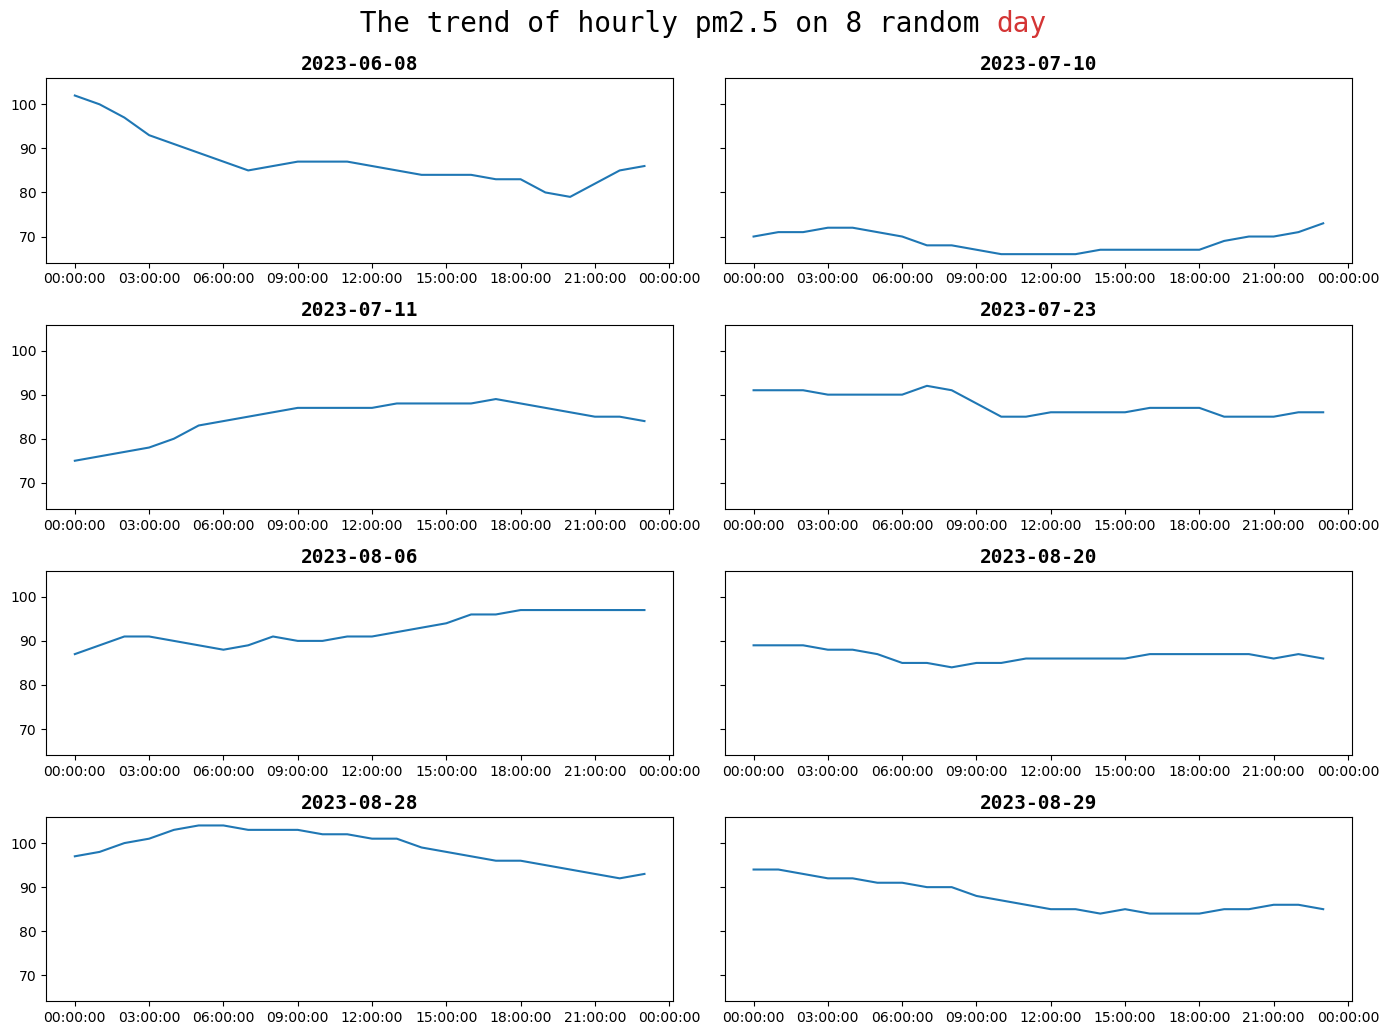

In [12]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='day',
    x='read_time',
    y='pm2.5'
)

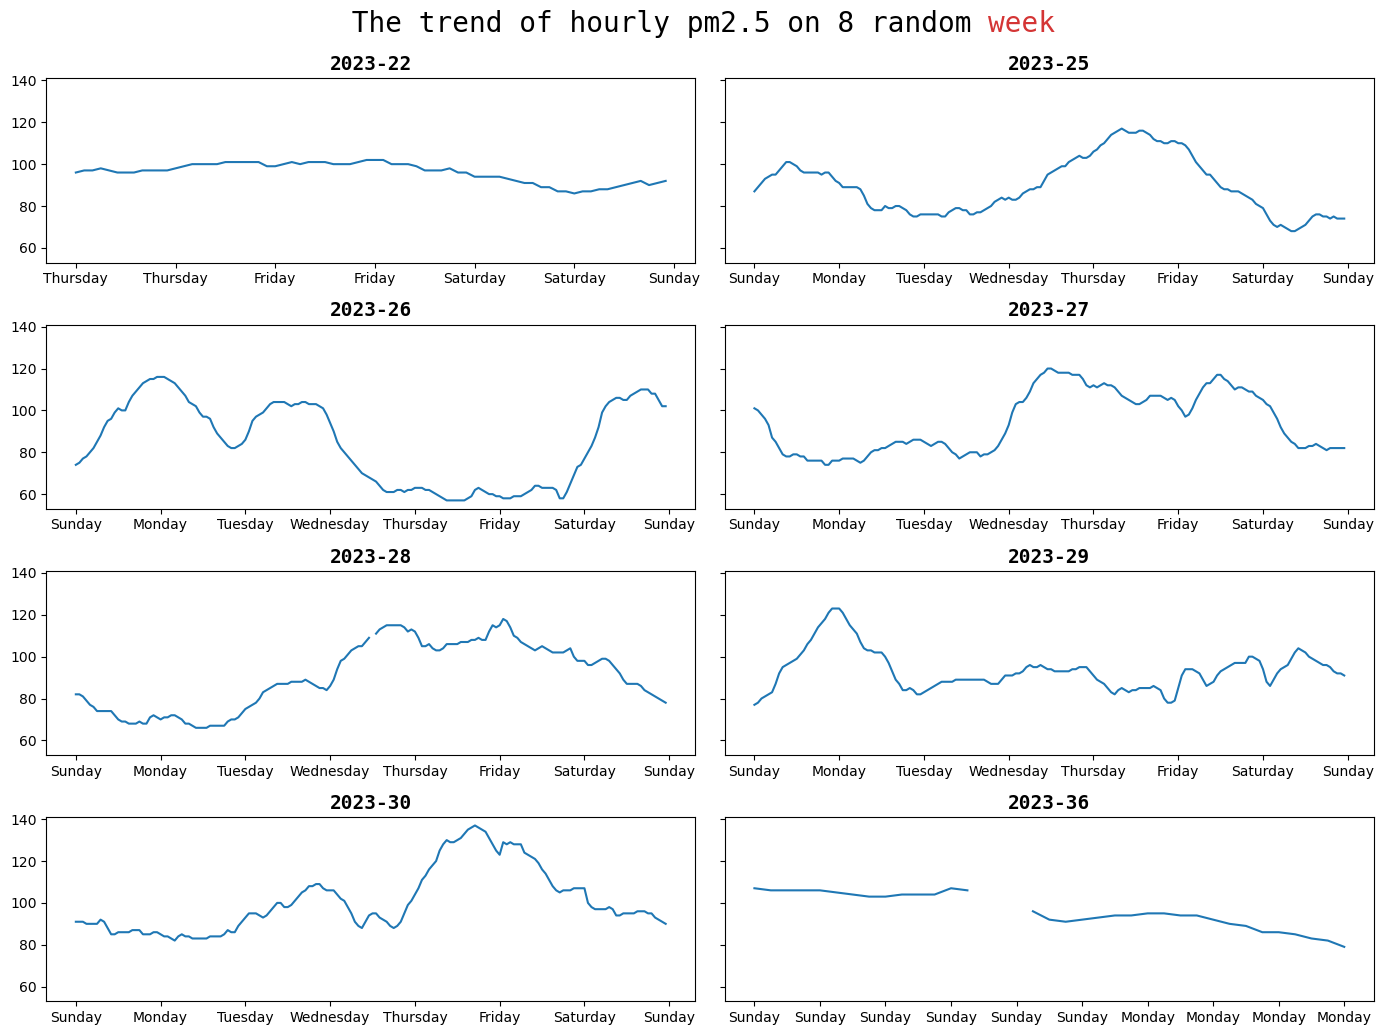

In [13]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='week',
    x='read_time',
    y='pm2.5'
)

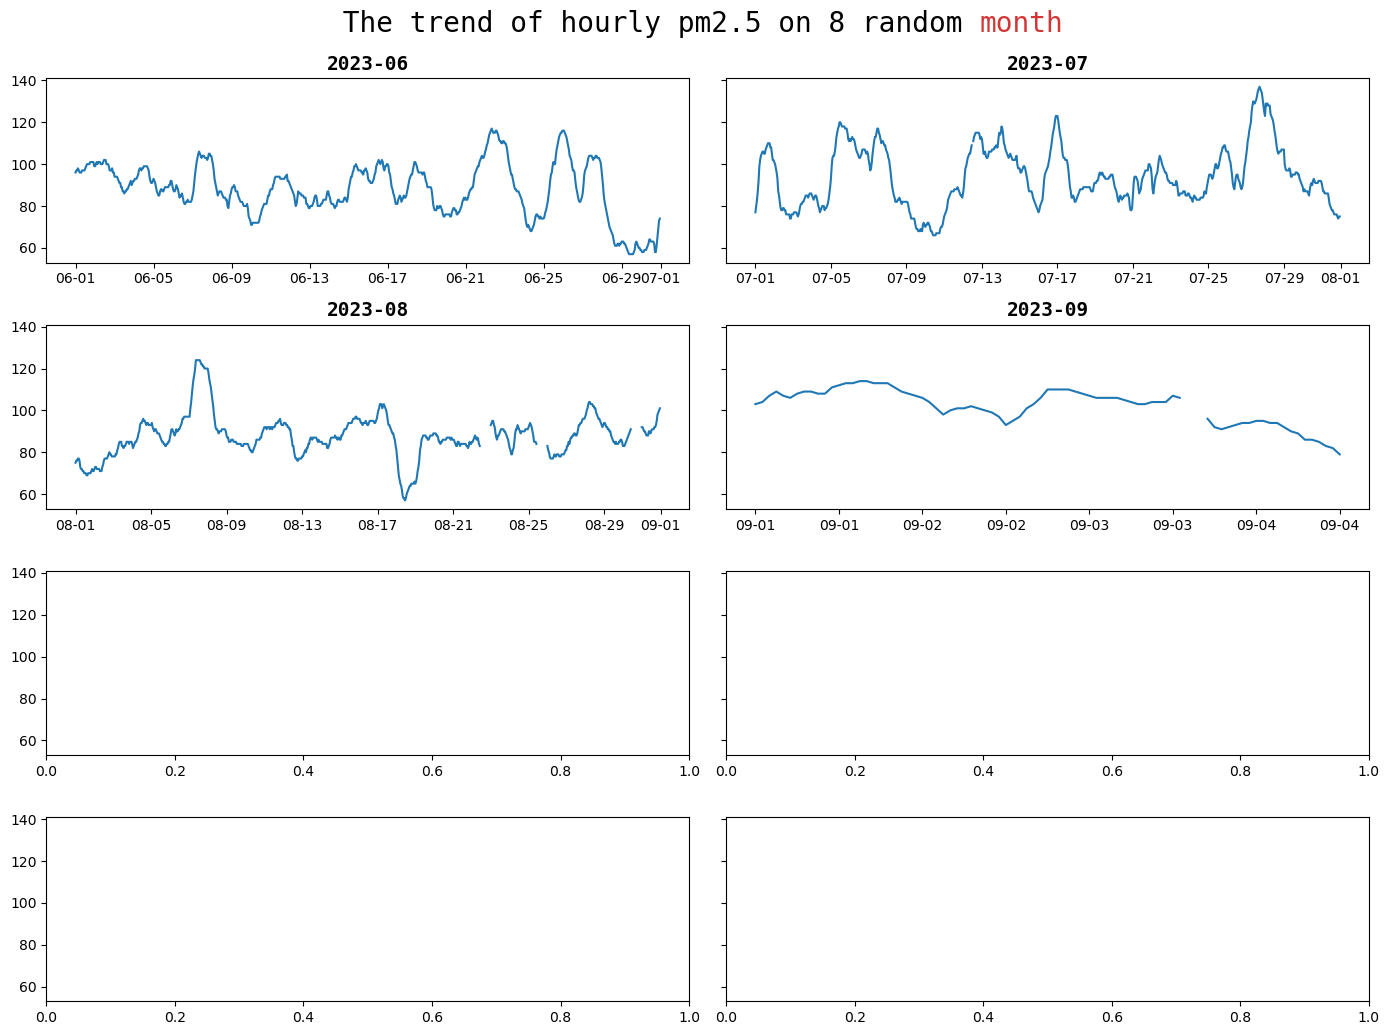

In [14]:
visualization.timely_plot(
    df = filtered_df,
    time_granularity='month',
    x='read_time',
    y='pm2.5'
)

## Heatmap Correlation Matrix

In [15]:
numeric_columns = processed_df.select_dtypes(include=['number'])#.drop(columns=['unnamed: 0'])

Text(0.5, 1.0, 'Correlation Matrix Heatmap for pm2.5 vs. Other Columns')

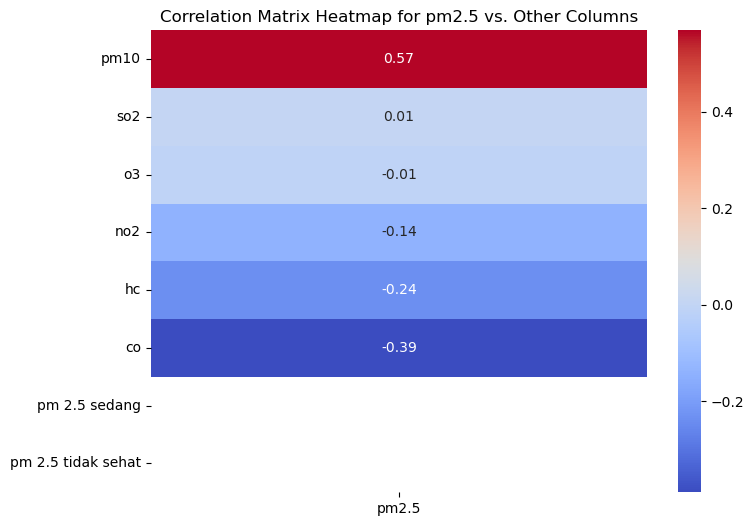

In [16]:
target_column = 'pm2.5'
correlations = pd.DataFrame(numeric_columns.corr()[target_column])
correlations = correlations.sort_values(by=target_column, ascending=False)
correlations.drop([target_column], inplace=True)
# correlations

plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f'Correlation Matrix Heatmap for {target_column} vs. Other Columns')

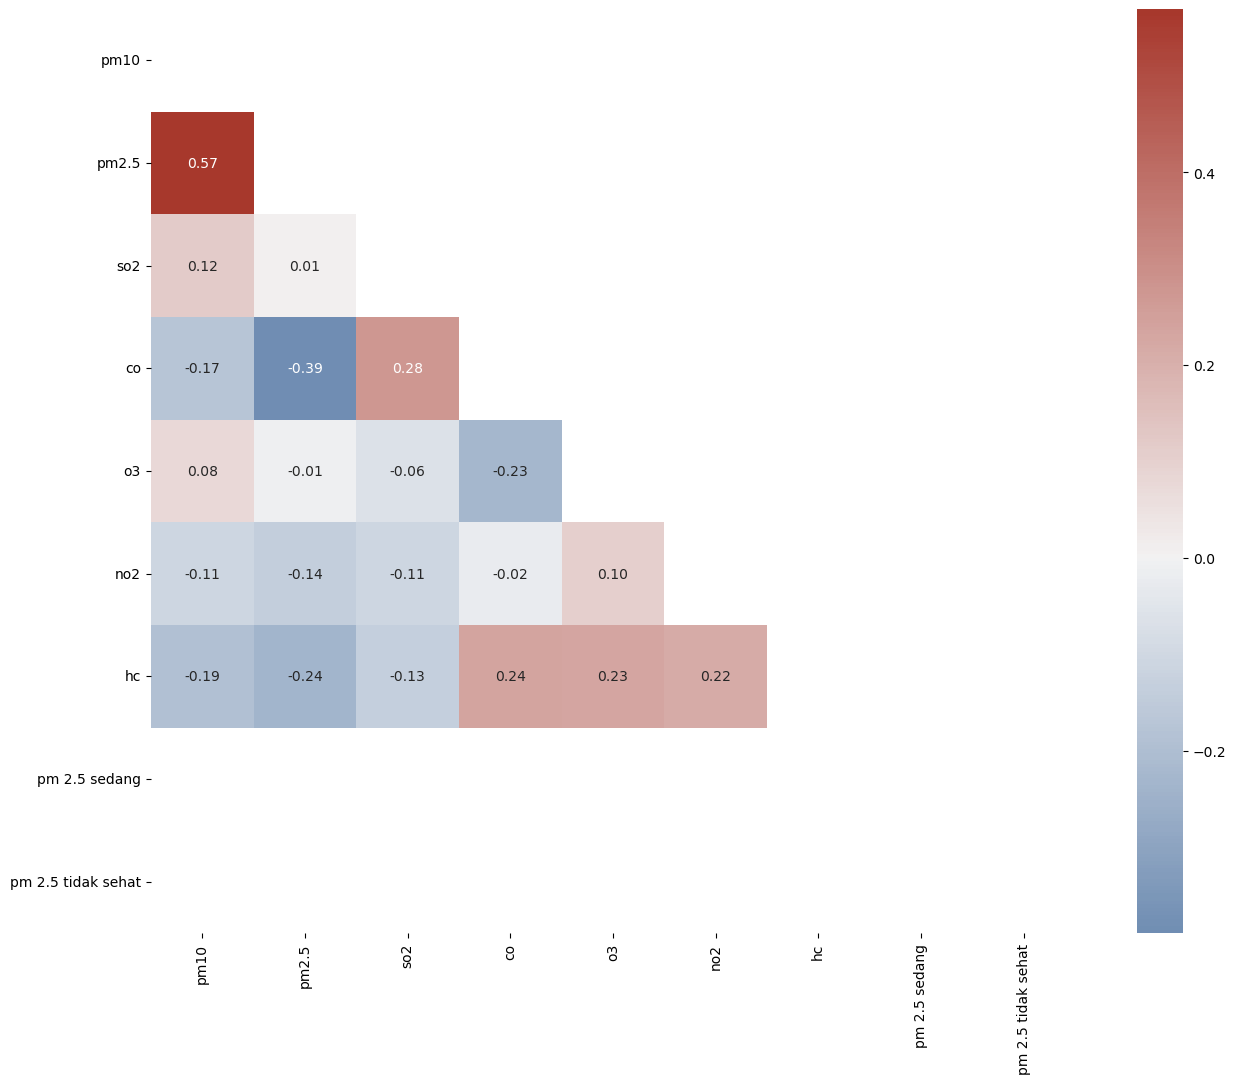

In [17]:
visualization.plot_correlation_heatmap(numeric_columns)

# Export raw df as processed df

In [18]:
usable_stasiun = [
    "Bekasi Kayuringin",
    "Bekasi Sukamahi",
    "Bogor Tanah Sereal",
    "Depok Pancoran Mas",
    "Karawang Wetan",
    "Tangerang Pasir Jaya"
]

In [19]:
processed_file_name = f"klhk_usable_nonimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

filtered_df = processed_df[processed_df["stasiun"].isin(usable_stasiun)]

overwrite = True
if overwrite or not os.path.exists(processed_file_path):
    filtered_df.to_csv(processed_file_path)
else:
    print("File already exists!")

In [20]:
processed_file_name = f"klhk_usable_linearimputed.csv"
processed_file_path = processed_data_dir / processed_file_name

filtered_df = processed_df[processed_df["stasiun"].isin(usable_stasiun)]
filtered_df = filtered_df.assign(lin_pm25=filtered_df['pm2.5'].interpolate(method='linear'))

overwrite = True
if overwrite or not os.path.exists(processed_file_path):
    filtered_df.to_csv(processed_file_path)
else:
    print("File already exists!")

In [21]:
filtered_df.stasiun.unique()

array(['Bekasi Kayuringin', 'Bekasi Sukamahi', 'Bogor Tanah Sereal',
       'Depok Pancoran Mas', 'Karawang Wetan', 'Tangerang Pasir Jaya'],
      dtype=object)

<Axes: xlabel='read_time'>

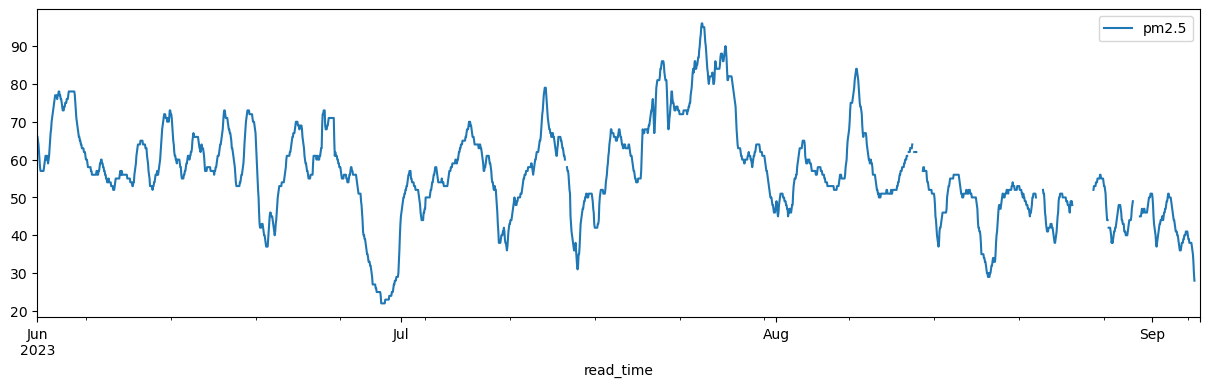

In [45]:
fig, ax = plt.subplots(figsize = (15,4))
processed_df[processed_df['stasiun']=="Depok Pancoran Mas"].plot(x='read_time',y='pm2.5',ax=ax)

<Axes: xlabel='read_time'>

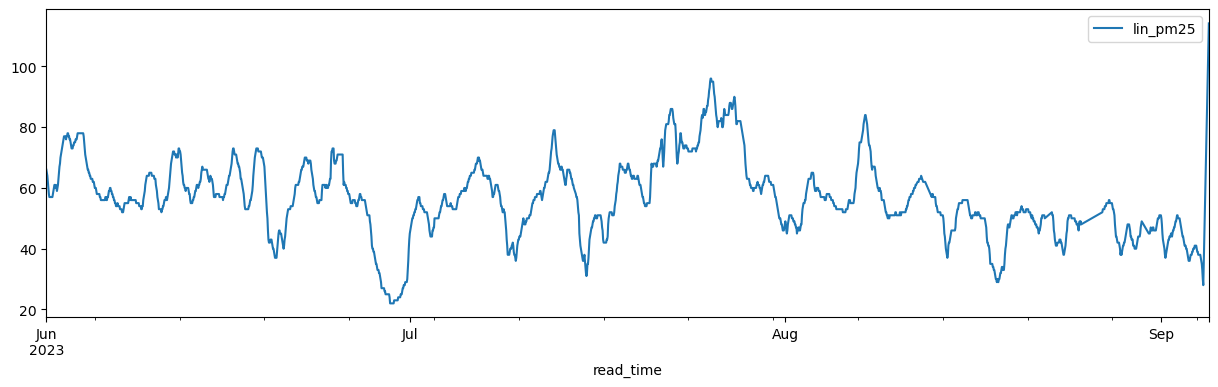

In [46]:
fig, ax = plt.subplots(figsize = (15,4))
filtered_df[filtered_df['stasiun']=="Depok Pancoran Mas"].plot(x='read_time',y='lin_pm25',ax=ax)

In [36]:
# stasiun_name = used_stasiun.lower().replace(" ","_")
# processed_file_name = f"klhk_{stasiun_name}.csv"
# processed_file_path = processed_data_dir / processed_file_name

# if not os.path.exists(processed_file_path):
#     filtered_df.to_csv(processed_file_path)
# else:
#     print("File already exist!")

In [6]:
stasiun_name = used_stasiun.lower().replace(" ","_")
processed_file_name = f"klhk_{stasiun_name}.csv"
processed_file_path = processed_data_dir / processed_file_name

filtered_df = pd.read_csv(processed_file_path)

In [26]:
season_check = filtered_df[['InterpolateLinear','read_time']]
season_check['read_time'] = pd.to_datetime(season_check['read_time'])
season_check = season_check.set_index('read_time')
season_check.head(2)

C:\Users\arasyidi\AppData\Local\Temp\ipykernel_25180\729535185.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  season_check['read_time'] = pd.to_datetime(season_check['read_time'])


,InterpolateLinear
read_time,
2023-06-01 00:00:00,96.0
2023-06-01 01:00:00,97.0


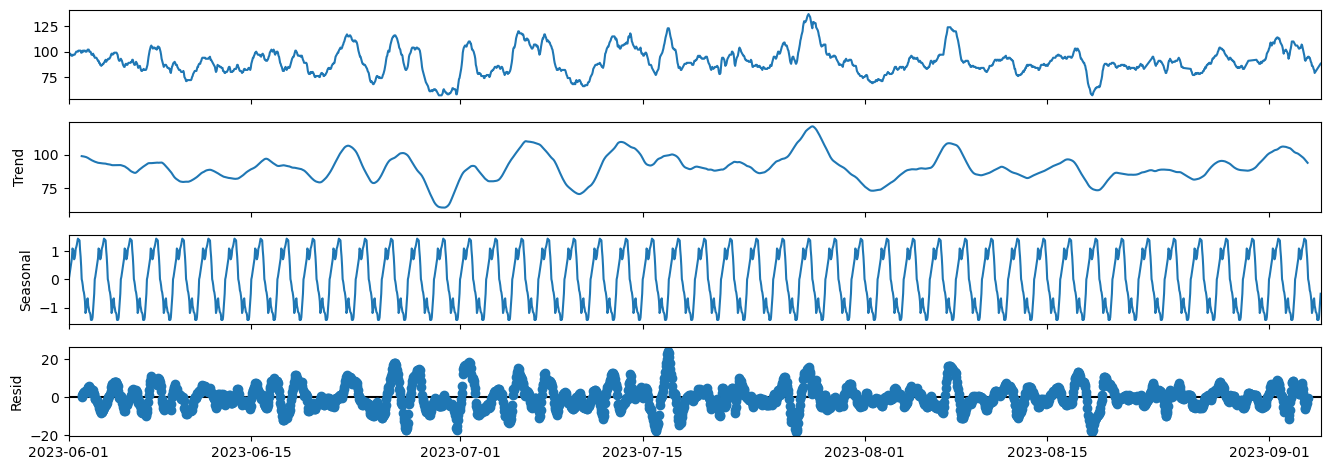

In [71]:
seasonality = seasonal_decompose(season_check, period=24*2)
seasonality.plot().set_figwidth(15)

C:\Users\arasyidi\AppData\Local\Temp\ipykernel_25180\4108845868.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, auto_cor, basefmt=' ', use_line_collection=True)


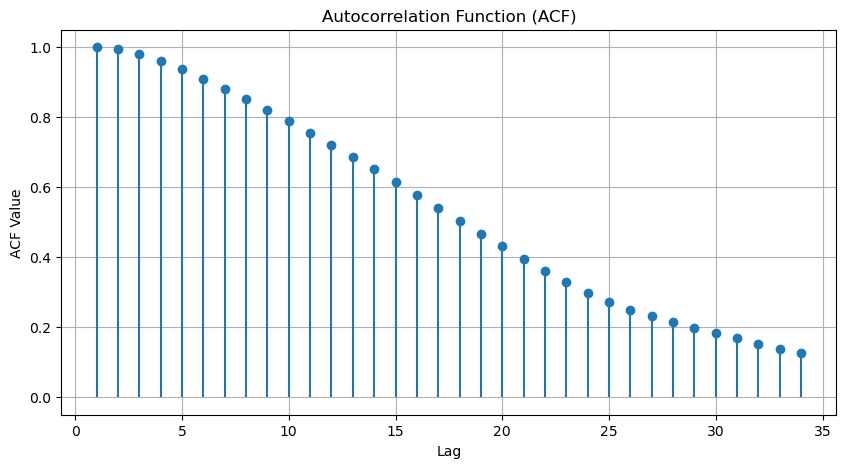

In [68]:
auto_cor = sm.tsa.acf(season_check)
# Plot the ACF
lags = range(1, len(auto_cor) + 1)
plt.figure(figsize=(10, 5))
plt.stem(lags, auto_cor, basefmt=' ', use_line_collection=True)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.grid(True)
plt.show()

C:\Users\arasyidi\AppData\Local\Temp\ipykernel_25180\825347814.py:5: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(lags, auto_cor, basefmt=' ', use_line_collection=True)


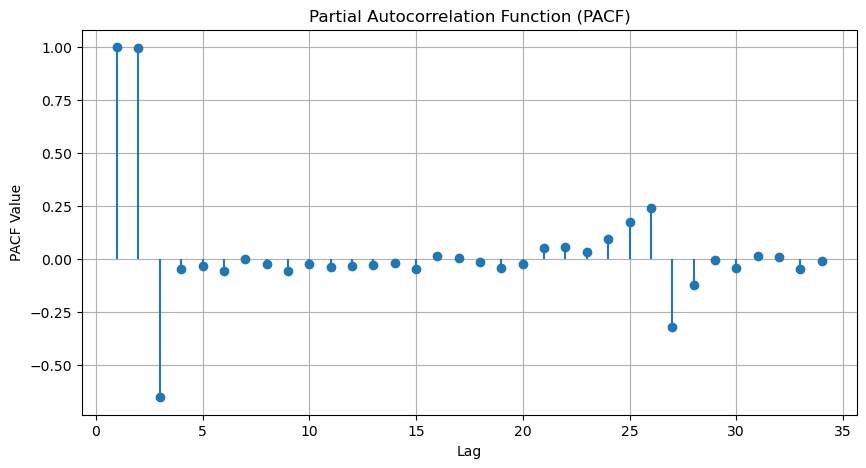

In [69]:
auto_cor = sm.tsa.pacf(season_check)
# Plot the ACF
lags = range(1, len(auto_cor) + 1)
plt.figure(figsize=(10, 5))
plt.stem(lags, auto_cor, basefmt=' ', use_line_collection=True)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lag')
plt.ylabel('PACF Value')
plt.grid(True)
plt.show()